#### Test filtering before and after curl in vorticity budget 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from xgcm import Grid
import filter
from dask.diagnostics import ProgressBar
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import glob, os

In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', orientation="horizontal", shrink=0.6)
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

In [3]:
# Filter set

def apply_gaussian_filter(field,wetMask,NL_g,sL_g,NB_g,sB_g):
    np = _get_array_module(field)

    fieldBar = field.copy()
    fieldBar = np.nan_to_num(fieldBar) 
    fieldBar = fieldBar * wetMask # Initalize the filtering process
    for i in range(NL_g):
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        fieldBar = fieldBar + (1/sL_g[i])*tempL # Update filtered field
    for i in range(NB_g): 
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        tempB = simple_Laplacian(tempL,wetMask) # Compute Biharmonic
        fieldBar = fieldBar + (2*np.real(sB_g[i])/np.abs(sB_g[i])**2)*tempL + (1/np.abs(sB_g[i])**2)*tempB
        
    return fieldBar

def apply_taper_filter(field,wetMask,NL_t,sL_t,NB_t,sB_t):
    np = _get_array_module(field)

    fieldBar = field.copy()
    fieldBar = np.nan_to_num(fieldBar) 
    fieldBar = fieldBar * wetMask # Initalize the filtering process
    for i in range(NL_t):
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        fieldBar = fieldBar + (1/sL_t[i])*tempL # Update filtered field
    for i in range(NB_t): 
        tempL = simple_Laplacian(fieldBar,wetMask) # Compute Laplacian
        tempB = simple_Laplacian(tempL,wetMask) # Compute Biharmonic
        fieldBar = fieldBar + (2*np.real(sB_t[i])/np.abs(sB_t[i])**2)*tempL + (1/np.abs(sB_t[i])**2)*tempB
        
    return fieldBar

def simple_Laplacian(phi,wetMask):
    np = _get_array_module(phi)

    out = phi.copy()
    out = np.nan_to_num(out) 
    out = wetMask * out 
    
    fac = (np.roll(wetMask, -1, axis=-1) 
            + np.roll(wetMask, 1, axis=-1) 
            + np.roll(wetMask, -1, axis=-2) 
            + np.roll(wetMask, 1, axis=-2)  
    )
        
    out = (- fac * out
            + np.roll(out, -1, axis=-1) 
            + np.roll(out, 1, axis=-1) 
            + np.roll(out, -1, axis=-2) 
            + np.roll(out, 1, axis=-2)
    )
        
    out = wetMask * out
    return out

try:
    from cupy import get_array_module as _get_array_module
except ImportError:
    import numpy as np

    def _get_array_module(*args):
        return np

# Laplacian steps: 12; # Biharmonic steps: 19


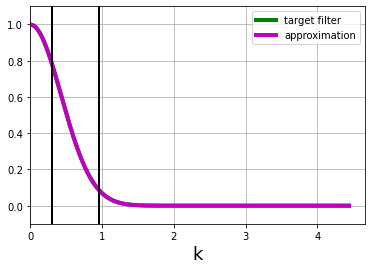

In [35]:
# Set Filter

# Guassian Filter set 

filter_fac = 8 # 1/8 --> 1 Deg

Lf_g = filter_fac/np.sqrt(6) 
N_g = 50
NL_g, sL_g, NB_g, sB_g = filter.filterSpec(N_g, 1, Lf_g, 'Gaussian')
print('# Laplacian steps: ' + str(NL_g) + '; # Biharmonic steps: ' + str(NB_g))

# Laplacian steps: 92; # Biharmonic steps: 4


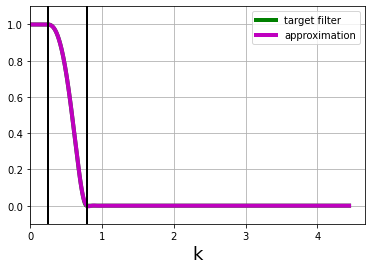

In [29]:
# Guassian Filter set 

filter_fac = 8 # 1/8 --> 1 Deg

Lf_t = filter_fac/2
N_t = 100
NL_t, sL_t, NB_t, sB_t = filter.filterSpec(N_t, 1, Lf_t, 'Taper')
print('# Laplacian steps: ' + str(NL_t) + '; # Biharmonic steps: ' + str(NB_t))

In [5]:
# Read data

ds = xr.open_dataset("/work/Hemant.Khatri/MOM6_idealised/MOM_budget/Global_MOM6/v3/Mom_Budget_OM125_0001_0005.nc")

ds = ds.sel(yh = slice(0,80.), yq = slice(0,80.), xh = slice(-100, 10.), xq = slice(-100, 10.))

print(ds)

<xarray.Dataset>
Dimensions:             (xh: 835, xq: 835, yh: 964, yq: 964)
Coordinates:
  * xh                  (xh) float64 -99.93 -99.78 -99.63 ... 9.657 9.773 9.888
  * yh                  (yh) float64 0.0 0.125 0.25 0.375 ... 79.84 79.89 79.95
  * xq                  (xq) float64 -100.0 -99.85 -99.7 ... 9.657 9.773 9.888
  * yq                  (yq) float64 0.0625 0.1875 0.3125 ... 79.86 79.92 79.97
Data variables:
    hf_CAu_2d           (yh, xq) float64 ...
    hf_CAv_2d           (yq, xh) float64 ...
    hf_PFu_2d           (yh, xq) float64 ...
    hf_PFv_2d           (yq, xh) float64 ...
    hf_diffu_2d         (yh, xq) float64 ...
    hf_diffv_2d         (yq, xh) float64 ...
    hf_du_dt_visc_2d    (yh, xq) float64 ...
    hf_dudt_2d          (yh, xq) float64 ...
    hf_dv_dt_visc_2d    (yq, xh) float64 ...
    hf_dvdt_2d          (yq, xh) float64 ...
    hf_gKEu_2d          (yh, xq) float64 ...
    hf_gKEv_2d          (yq, xh) float64 ...
    hf_rvxu_2d          (yq, xh) f

In [19]:
# Double precision static file

ppdir = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210308/CM4_piControl_c192_OM4p125_f8static/gfdl.ncrc4-intel18-prod-openmp/history/"
ds_grid = xr.open_dataset(ppdir + "01010101.ocean_static.nc")

ds_grid = ds_grid.isel(xq = slice(0,2880), yq=slice(0,2240))

ds_grid = ds_grid.drop('time')

ds_grid = ds_grid.sel(yh = slice(0,80.), yq = slice(0,80.), xh = slice(-100, 10.), xq = slice(-100, 10.))

In [6]:
print(np.finfo(ds.intz_CAu_2d))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------



In [8]:
# Create grid and interpolate depth, beta

grid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'} }, periodic=[ ])

depth_u = grid.interp(ds['deptho'], 'X',  boundary='fill') 
depth_v = grid.interp(ds['deptho'], 'Y',  boundary='fill')
depth_q = grid.interp(depth_u, 'Y',  boundary='fill')

colh_u = grid.interp(ds['col_height'], 'X',  boundary='fill') 
colh_v = grid.interp(ds['col_height'], 'Y',  boundary='fill')

beta_u =  grid.diff(ds['Coriolis'], 'Y',  boundary='fill') / ds['dyCu']
beta_v = grid.interp(grid.interp(beta_u, 'X',  boundary='fill'), 'Y',  boundary='fill')

In [22]:
rho_0 = 1035.

BPT = xr.Dataset()

vmo_bv = (beta_v * ds['vmo'] / (rho_0 * ds['dxCv'])).load()
vmo_bv = grid.interp(vmo_bv, 'X',  boundary='fill')

vmo_bv = vmo_bv.assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

BPT_1 = ( - grid.diff((ds['intz_PFu_2d'] + ds['intz_u_BT_accel_2d']) * ds_grid.dxCu, 'Y', boundary='fill')
           + grid.diff((ds['intz_PFv_2d'] + ds['intz_v_BT_accel_2d']) * ds_grid.dyCv, 'X', boundary='fill') 
          ) / ds_grid.areacello_bu

%time BPT['BPT'] = (BPT_1.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

%time BPT['vmo_bv'] = (vmo_bv.load())

%time BPT['depth'] = (depth_q.load())

CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 2.49 ms
CPU times: user 5 ms, sys: 6 ms, total: 11 ms
Wall time: 14.8 ms
CPU times: user 1 ms, sys: 0 ns, total: 1 ms
Wall time: 1.45 ms


### Guassian filter

In [36]:
dataBar = (ds['intz_PFu_2d'] + ds['intz_u_BT_accel_2d']).copy() # Initialize the filtering process
dataBar = dataBar * ds_grid['areacello_cu']

dims = ['yh', 'xq']
dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet_u'], NL_g, sL_g, NB_g, sB_g, 
                        input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                        output_dtypes=[dataBar.dtype], dask='parallelized')

dataBar = xr.where(ds['wet_u'],dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds_grid['areacello_cu'] # divide by cell area    

px = dataBar.copy()

dims = ['yq', 'xh']
dataBar = (ds['intz_PFv_2d'] + ds['intz_v_BT_accel_2d']).copy() # Initialize the filtering process
dataBar = dataBar * ds_grid['areacello_cv']

dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet_v'], NL_g, sL_g, NB_g, sB_g, 
                        input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                        output_dtypes=[dataBar.dtype], dask='parallelized')

dataBar = xr.where(ds['wet_v'],dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds_grid['areacello_cv'] # divide by cell area    

py = dataBar.copy()


In [37]:
BPT_2 = ( - grid.diff(px * ds_grid.dxCu, 'Y', boundary='fill') + grid.diff(py * ds_grid.dyCv, 'X', boundary='fill') 
          ) / ds_grid.areacello_bu

%time BPT['BPT1'] = (BPT_2.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.58 ms


In [38]:
dims = ['yq', 'xq']
dataBar = BPT['BPT'].copy() # Initialize the filtering process
dataBar = dataBar * ds_grid['areacello_bu']

dataBar = xr.apply_ufunc(apply_gaussian_filter, dataBar, ds['wet_c'], NL_g, sL_g, NB_g, sB_g, 
                        input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                        output_dtypes=[dataBar.dtype], dask='parallelized')

dataBar = xr.where(ds['wet_c'],dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds_grid['areacello_bu'] # divide by cell area    

%time BPT['BPT2'] = (dataBar.copy()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

CPU times: user 5 ms, sys: 0 ns, total: 5 ms
Wall time: 4.84 ms


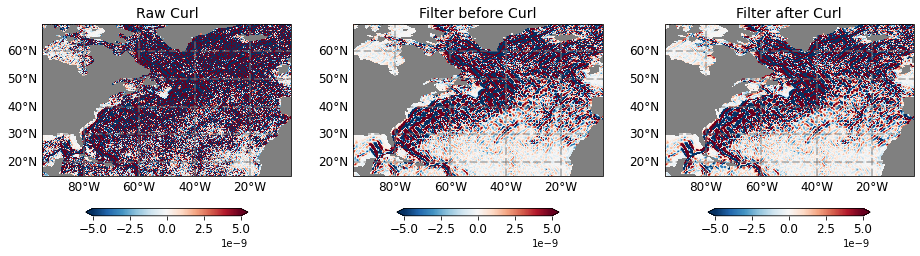

In [39]:
max_r = 5.e-9
lat_lon_ext = [-95., -5., 15., 70.]

grid1 = plt.GridSpec(1, 3, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[16,4])

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT['BPT'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Raw Curl')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT['BPT1'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Filter before Curl')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT['BPT2'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Filter after Curl')

### Taper Filter

In [31]:
dataBar = (ds['intz_PFu_2d'] + ds['intz_u_BT_accel_2d']).copy() # Initialize the filtering process
dataBar = dataBar * ds_grid['areacello_cu']

dims = ['yh', 'xq']
dataBar = xr.apply_ufunc(apply_taper_filter, dataBar, ds['wet_u'], NL_t, sL_t, NB_t, sB_t, 
                        input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                        output_dtypes=[dataBar.dtype], dask='parallelized')

dataBar = xr.where(ds['wet_u'],dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds_grid['areacello_cu'] # divide by cell area    

px = dataBar.copy()

dims = ['yq', 'xh']
dataBar = (ds['intz_PFv_2d'] + ds['intz_v_BT_accel_2d']).copy() # Initialize the filtering process
dataBar = dataBar * ds_grid['areacello_cv']

dataBar = xr.apply_ufunc(apply_taper_filter, dataBar, ds['wet_v'], NL_t, sL_t, NB_t, sB_t, 
                        input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                        output_dtypes=[dataBar.dtype], dask='parallelized')

dataBar = xr.where(ds['wet_v'],dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds_grid['areacello_cv'] # divide by cell area    

py = dataBar.copy()

In [32]:
BPT_2 = ( - grid.diff(px * ds_grid.dxCu, 'Y', boundary='fill') + grid.diff(py * ds_grid.dyCv, 'X', boundary='fill') 
          ) / ds_grid.areacello_bu

%time BPT['BPT1t'] = (BPT_2.load()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 3.37 ms


In [33]:
dims = ['yq', 'xq']
dataBar = BPT['BPT'].copy() # Initialize the filtering process
dataBar = dataBar * ds_grid['areacello_bu']

dataBar = xr.apply_ufunc(apply_taper_filter, dataBar, ds['wet_c'], NL_t, sL_t, NB_t, sB_t, 
                        input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                        output_dtypes=[dataBar.dtype], dask='parallelized')

dataBar = xr.where(ds['wet_c'],dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds_grid['areacello_bu'] # divide by cell area    

%time BPT['BPT2t'] = (dataBar.copy()).assign_coords({'geolat_c': ds['geolat_c'], 'geolon_c': ds['geolon_c']})

CPU times: user 6 ms, sys: 0 ns, total: 6 ms
Wall time: 5.52 ms


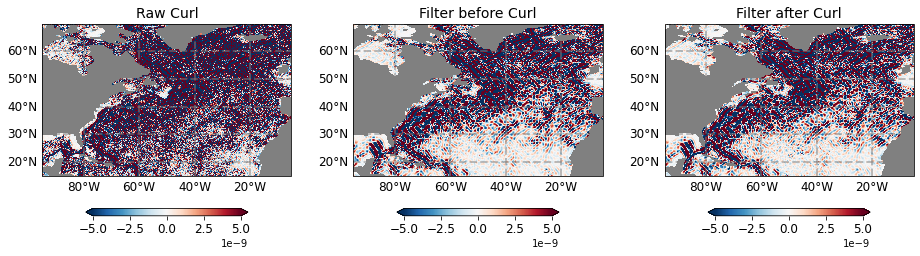

In [34]:
max_r = 5.e-9
lat_lon_ext = [-95., -5., 15., 70.]

grid1 = plt.GridSpec(1, 3, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[16,4])

ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT['BPT'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Raw Curl')

ax = fig.add_subplot(grid1[0, 1], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT['BPT1t'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Filter before Curl')

ax = fig.add_subplot(grid1[0, 2], projection=ccrs.PlateCarree(),facecolor='grey')
_ = plot_sec(ax, BPT['BPT2t'], vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, lat_lon_ext = lat_lon_ext,
                   lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title='Filter after Curl')

In [45]:
print(np.finfo(BPT['BPT1t']))

Machine parameters for float64
---------------------------------------------------------------
precision =  15   resolution = 1.0000000000000001e-15
machep =    -52   eps =        2.2204460492503131e-16
negep =     -53   epsneg =     1.1102230246251565e-16
minexp =  -1022   tiny =       2.2250738585072014e-308
maxexp =   1024   max =        1.7976931348623157e+308
nexp =       11   min =        -max
---------------------------------------------------------------



In [54]:
rho_0 = 1035.0
div_u = (grid.diff(ds['umo'] / (rho_0* ds['dyCu']) , 'X', boundary='fill')/ ds['dxt'] + 
         grid.diff(ds['vmo'] / (rho_0* ds['dxCv']), 'Y', boundary='fill')/ ds['dyt']) 

In [62]:
dataBar = (ds['umo'] / (rho_0* ds['dyCu']* ds['wet_u'])).copy() # Initialize the filtering process
dataBar = dataBar * ds_grid['areacello_cu']

dims = ['yh', 'xq']
dataBar = xr.apply_ufunc(apply_taper_filter, dataBar, ds['wet_u'], NL_t, sL_t, NB_t, sB_t, 
                        input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                        output_dtypes=[dataBar.dtype], dask='parallelized')

dataBar = xr.where(ds['wet_u'],dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds_grid['areacello_cu'] # divide by cell area    

ut = dataBar.copy()

dims = ['yq', 'xh']
dataBar = (ds['vmo'] / (rho_0* ds['dxCv'] *ds['wet_v'])).copy() # Initialize the filtering process
dataBar = dataBar * ds_grid['areacello_cv']

dataBar = xr.apply_ufunc(apply_taper_filter, dataBar, ds['wet_v'], NL_t, sL_t, NB_t, sB_t, 
                        input_core_dims=[dims,dims, [], [], [], []],output_core_dims=[dims], 
                        output_dtypes=[dataBar.dtype], dask='parallelized')

dataBar = xr.where(ds['wet_v'],dataBar,np.nan) # mask by nan's if on land
dataBar = dataBar/ds_grid['areacello_cv'] # divide by cell area    

vt = dataBar.copy()

In [63]:
div_ut = (grid.diff(ut , 'X', boundary='fill')/ ds['dxt'] + grid.diff(vt, 'Y', boundary='fill')/ ds['dyt']) 

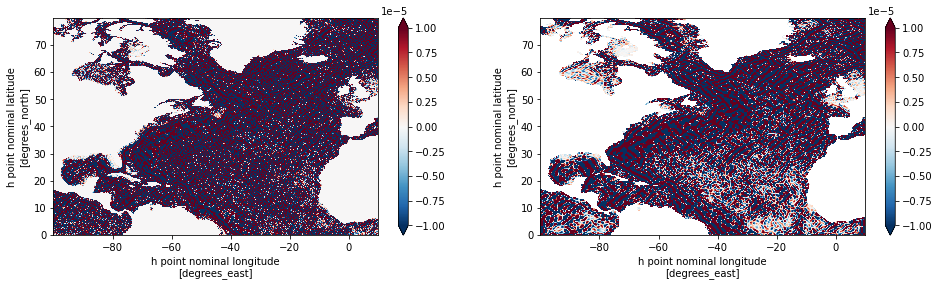

In [65]:
fig = plt.figure(figsize=[16,4])

plt.subplot(1,2,1)
div_u.plot(vmin=-1e-5, vmax=1e-5, cmap='RdBu_r')

plt.subplot(1,2,2)
div_ut.plot(vmin=-1e-5, vmax=1e-5, cmap='RdBu_r')

In [53]:
print(np.finfo(div_u))

Machine parameters for float32
---------------------------------------------------------------
precision =   6   resolution = 1.0000000e-06
machep =    -23   eps =        1.1920929e-07
negep =     -24   epsneg =     5.9604645e-08
minexp =   -126   tiny =       1.1754944e-38
maxexp =    128   max =        3.4028235e+38
nexp =        8   min =        -max
---------------------------------------------------------------

